# Understanding MLPs: Activations and Gradients

Till now we have created a simple MLP and trained it on the names dataset. Let us now try to get an even better intuition around how these neural networks learn and how these indivisual neurons's activation works. The reason to understand this is that this givesus an undrstanding around why RNN or different types of NN were created.

## Understanding issues with initialization

### Fixing the initial loss

Currently we see that the initial loss of the first forward pass is 27 and then it drops down to 2. The initial loss is high becuase our weight initialization and logits are not good. In the initial forward pass, our logits should be of a uniform distribution where the probability of each class is 1/vocab_size. Usually, we want the initial logits to be close to 0. 

1. We usually initialize the weights to be close to 0. We multiply the weights with a small number so that the initial part of our neural network works in learning instead of squashing down the weights.
2. The reason we do not multiply them with 0 is the gradients of the loss function will be 0.

### Fixing the Saturated TanH

If we create a histogram of our tanh function and see the distribution, we can see that the tanh function is near 1 and -1 for most of the values. The derivative of tanh is 1 - tanh^2(x). So, for values close to 1 and -1, the derivative will be close to 0. Intuitively this makes sense. If the output of the tanh function is close to 1 or -1, then changing the weights and bias of the input will not change the tanh significantly. 

There are cases in which whatever input we give to the tanh neuron, it always gives outputs of -1 or 1, which means that it will never learn. We can make the preactivations between -1 and 1 by multiplying W1 with 0.01. 

### Kaiming Initialization

https://arxiv.org/abs/1502.01852
Till now we have been taking random guesses around the initialization and trying to find the best initialization. Kaiming Initialization gives a structured way around this. It is important that the activations and the gradients flow through the network correctly. The paper tells us that while initialization we should divide the weights by the square root of the number of inputs multiplied by a small factor depending on the non-linearity that we use. In the older days of machine learning, the choice of non-linearity and the initialization and regularization terms used to matter but with modern techniques like batch normalization and adam optimiser, these things do not matter a LOT.

## Batch Normalization

Batch normalization is a technique that normalizes the activations of a layer by subtracting the mean and dividing by the standard deviation of the activations. This is done at each training step and helps to stabilize the training process. We also realise that this operation is perfectly differentiable. We also introduce the concept of gain and bias to the batch normalization layer. Gain and bias are learnable parameters that are used to scale and shift the normalized activations.

Let us assume that we have a hidden layer. Once we have calculate the pre activations using the linear function, we can apply batch normalization to it. The batch normalization layer will calculate the mean and standard deviation of the prev-activations and subtract the mean and divide by the standard deviation.

Let x be the pre-activation of the layer. Then the batch normalization will be:

$$x' = \text{gain} \cdot \frac{x - \text{mean}(x)}{\sqrt{\text{var}(x) + \epsilon}} + \text{bias}$$

Batch normalization is a great normalization technique and still used widely in the industry.

1. Batch Normalization takes the minibatch and normalizes it. That means that OTHER inputs to the neural network afffect the output of the main input. Lets assume I am predicting the next character for 'emm' then all the examples in the batch affect the output of this input. This is a quality that is undesired in a normalizer. The issue also comes during inference. Since during forward pass we are normalizing the batch inputs, for a single input what should the normalized linear output be? For that we once the training loop is done, we calculate the mean and std for the training set and set it and use it to do inference.

2. Usually in batch normalization, the bias term of the linear layer gets cancelled out. Hence adding that bias term is not required.


In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline
import random

In [2]:
words = open("names.txt", "r").read().splitlines()
words[:8]

# Build the vocabulary of characters
chars = sorted(list(set(''.join(words))))
stoi = {s:i + 1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(stoi)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [3]:
n_embd = 10 # The embedding vector size of the MLP
n_hidden = 200 # The hidden size of the MLP
block_size = 3 # This is the context length of how many characters we use to predict the next character
max_steps = 200000
batch_size = 32
g = torch.Generator().manual_seed(2147483647)

In [4]:
# Creating the Dataset
def build_dataset(words):
    X, Y = [], []

    for w in words:
        context = ['.'] * block_size
        w = context + list(w) + ['.']

        for i in range(len(w) - block_size):
            current_context = w[i:i+block_size]
            target = w[i+block_size]
            X.append([stoi[c] for c in current_context])
            Y.append(stoi[target])

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

In [5]:
def get_params():
    # Let us create a more easy to read forward pass and loss function for the neural network.
    C = torch.randn((vocab_size, n_embd), generator=g)

    kaiming_factor = ((5 / 3) / (block_size * n_embd) ** 0.5) #Kaiming Initialization for the first layer
    W1 = torch.randn((block_size * n_embd, n_hidden), generator=g) * kaiming_factor

    kaiming_factor = ((5 / 3) / (n_hidden) ** 0.5) #Kaiming Initialization for the second layer
    W2 = torch.randn((n_hidden, vocab_size), generator=g) * kaiming_factor
    b2 = torch.randn((1, vocab_size), generator=g) * 0
    
    bngains = torch.ones((1, n_hidden))
    bnbias = torch.zeros((1, n_hidden))

    for p in [C, W1, W2, b2, bngains, bnbias]:
        p.requires_grad = True

    print(torch.tensor([i.nelement() for i in[C, W1, W2, b2, bngains, bnbias]]).sum())
    return C, W1, W2, b2, bngains, bnbias

In [6]:
def training_loop(X, Y, params):
        # Training Loop
    C, W1, W2, b2, bngains, bnbias = params
    lossi = []
    for i in range(max_steps):
        # Minibatch construct
        ix = torch.randint(0, X.shape[0], (batch_size,), generator=g)
        
        # Forward Pass
        emb = C[X[ix]]
        embcat = emb.view(emb.shape[0], -1)
        hpreact = embcat @ W1
        hpreact = (bngains * (hpreact - hpreact.mean(dim=0, keepdim=True)) / hpreact.std(dim=0, keepdim=True)) + bnbias # We are doing batch normalization here
        h = torch.tanh(hpreact)
        logits = h @ W2 + b2
        loss = F.cross_entropy(logits, Y[ix])

        # Backward Pass
        for p in params:
            p.grad = None
        loss.backward()

        # Update
        lr = 0.1 if i < 100000 else 0.01
        for p in params:
            p.data += -lr * p.grad

        if i % 10000 == 0:
            print(f"Step {i}: Loss {loss.item()}")
        lossi.append(loss.item())

In [7]:
def calibrate_batchnorm(params, X):
    with torch.no_grad():
        C, W1, W2, b2, bngains, bnbias = params
        emb = C[X]
        embcat = emb.view(emb.shape[0], -1)
        hpreact = embcat @ W1
        bnmean = hpreact.mean(dim=0, keepdim=True)
        bnstd = hpreact.std(dim=0, keepdim=True)
        
    return bnmean, bnstd

In [8]:
@torch.no_grad() # This decorator will disable gradient tracking
def split_loss(split, params, X, Y, bnmean, bnstd):
    C, W1, W2, b2, bngains, bnbias = params
    emb = C[X]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1
    hpreact = (bngains * (hpreact - bnmean) / bnstd) + bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y)
    print(split, loss.item())

### Training and checking the loss

In [9]:
# Now we can create the training, validation and test splits.
random.seed(42)
random.shuffle(words)

n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [10]:
# Get params
params = get_params()

tensor(12097)


In [11]:
# Run the training loop
for _ in range(1):
    training_loop(Xtr, Ytr, params)

Step 0: Loss 4.135707378387451
Step 10000: Loss 2.027794361114502
Step 20000: Loss 2.6558220386505127
Step 30000: Loss 2.0230014324188232
Step 40000: Loss 2.278702974319458
Step 50000: Loss 1.8605955839157104
Step 60000: Loss 2.068042516708374
Step 70000: Loss 2.355236291885376
Step 80000: Loss 2.34657621383667
Step 90000: Loss 2.131535530090332
Step 100000: Loss 2.313046455383301
Step 110000: Loss 2.2492730617523193
Step 120000: Loss 1.6537268161773682
Step 130000: Loss 1.916322112083435
Step 140000: Loss 2.287675380706787
Step 150000: Loss 1.9321362972259521
Step 160000: Loss 2.0253751277923584
Step 170000: Loss 2.3683671951293945
Step 180000: Loss 2.084022045135498
Step 190000: Loss 2.0807290077209473


In [12]:
def eval_loss():
    bnmean, bnstd = calibrate_batchnorm(params, Xtr)
    split_loss('train', params, Xtr, Ytr, bnmean, bnstd)
    bnmean, bnstd = calibrate_batchnorm(params, Xdev)
    split_loss('val', params, Xdev, Ydev, bnmean, bnstd)

eval_loss()

train 2.0714268684387207
val 2.110138416290283


## Pytorchifing the MLP

Till now, we have been using our own implementation of the MLP. Let us understand how Pytorch implements the same by taking example of this small neural netwok.

In [17]:
# This describes one linear layer
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / (fan_in ** 0.5) # Kaiming Initialization
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

In [18]:
class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True

        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)

        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
    
    def __call__(self, x):
        if self.training:
            xmean = x.mean(0, keepdim=True)
            xvar = x.var(0, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var

        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta

        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

In [19]:
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []

In [28]:
n_emb = 10
n_hidden = 100
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_emb), generator=g)

layers = [
    Linear(n_emb * block_size, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size), BatchNorm1d(vocab_size),
]

# This wont matter much becuase we are using batch norm
with torch.no_grad():
    layers[-1].gamma *= 0.1
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5 / 3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

47551


In [29]:
# Now we can create the training, validation and test splits.
random.seed(42)
random.shuffle(words)

n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182437, 3]) torch.Size([182437])
torch.Size([22781, 3]) torch.Size([22781])
torch.Size([22928, 3]) torch.Size([22928])


In [30]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # Minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    # Forward Pass
    emb = C[Xb]
    x = emb.view(emb.shape[0], -1) #Concatenate the vectors
    for layer in layers:
        x = layer(x)

    loss = F.cross_entropy(x, Yb)

    # backward pass
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()

    # Update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # Track Stats
    if i % 10000 == 0:
        print(f"Step {i}: Loss {loss.item()}")
    lossi.append(loss.log10().item())

    break

Step 0: Loss 3.3135876655578613


layer 2 (      Tanh): mean -0.01, std 0.63, saturated: 3.09%
layer 5 (      Tanh): mean +0.00, std 0.64, saturated: 2.78%
layer 8 (      Tanh): mean +0.00, std 0.64, saturated: 3.31%
layer 11 (      Tanh): mean +0.00, std 0.64, saturated: 3.28%
layer 14 (      Tanh): mean -0.00, std 0.64, saturated: 2.81%


Text(0.5, 1.0, 'activation distribution')

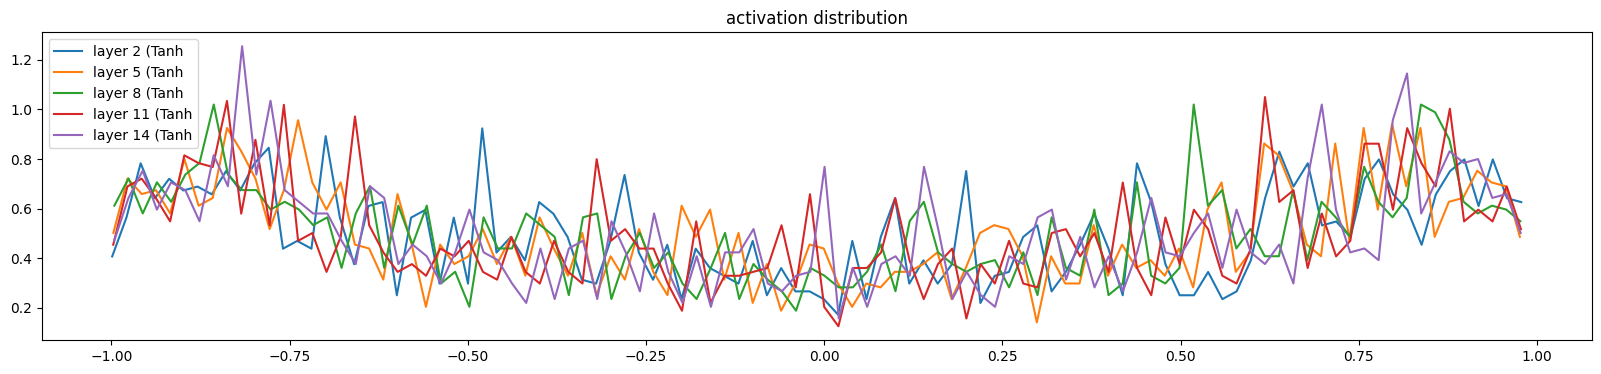

In [31]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')